
## ARIMA and Seasonal ARIMA  ##

The general process for ARIMA models is the following:

* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date,timedelta
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

In [38]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=3000)).strftime("%Y-%m-%d")

In [39]:
print("Start_date : ",start_date)
print("End_date : ",end_date)

Start_date :  2021-11-21
End_date :  2024-08-17


In [40]:
ticker = 'GOOGL'
df = yf.download(ticker,start=start_date,end=end_date,progress=False)

In [41]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-22,149.332504,149.829498,146.147507,146.302002,146.134277,30594000
2021-11-23,146.153000,146.660004,144.115005,145.781998,145.614883,27218000
2021-11-24,145.473495,146.249496,144.373001,146.119995,145.952484,18040000
2021-11-26,144.348495,144.557495,141.842499,142.182999,142.020004,30470000
2021-11-29,144.000000,146.297501,143.893494,145.530502,145.363663,32596000


In [42]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-12,164.350006,164.899994,161.839996,162.289993,162.289993,15895300
2024-08-13,163.410004,164.729996,162.970001,164.160004,164.160004,18551700
2024-08-14,162.399994,163.220001,157.710007,160.369995,160.369995,40591100
2024-08-15,160.500000,161.639999,159.610001,161.300003,161.300003,31524300
2024-08-16,161.470001,165.059998,161.130005,162.960007,162.960007,24185000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 687 entries, 2021-11-22 to 2024-08-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       687 non-null    float64
 1   High       687 non-null    float64
 2   Low        687 non-null    float64
 3   Close      687 non-null    float64
 4   Adj Close  687 non-null    float64
 5   Volume     687 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 37.6 KB


In [44]:
df_cleaned = df[['Close']]

In [45]:
df_cleaned.head()

,Close
Date,
2021-11-22,146.302002
2021-11-23,145.781998
2021-11-24,146.119995
2021-11-26,142.182999
2021-11-29,145.530502


converting data column into datetime format inorder to maintain sequence of each stock price

# Visualize the data #

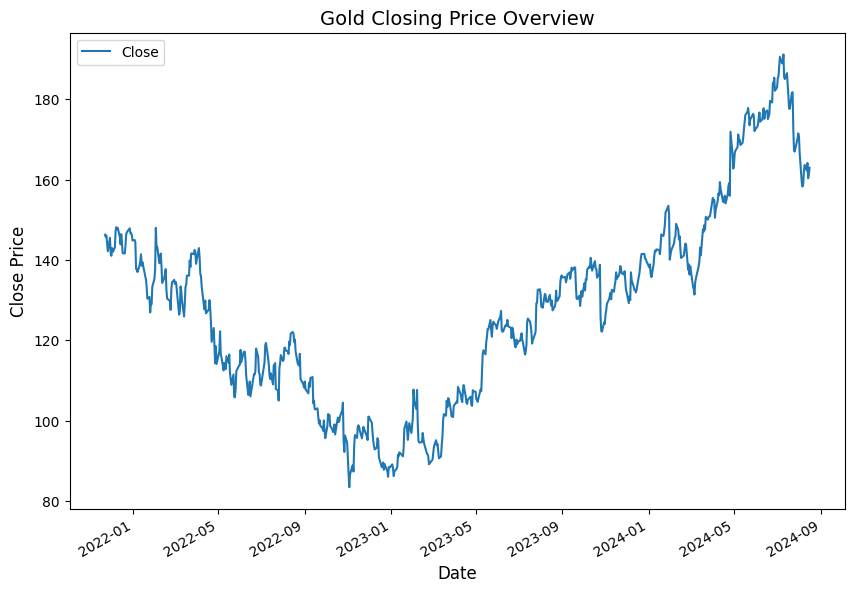

In [46]:
# Plotting with customization
ax = df_cleaned.plot(figsize=(10, 7), legend=True)

# Adding a title and axis labels
ax.set_title('Gold Closing Price Overview', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Display the plot
plt.show()

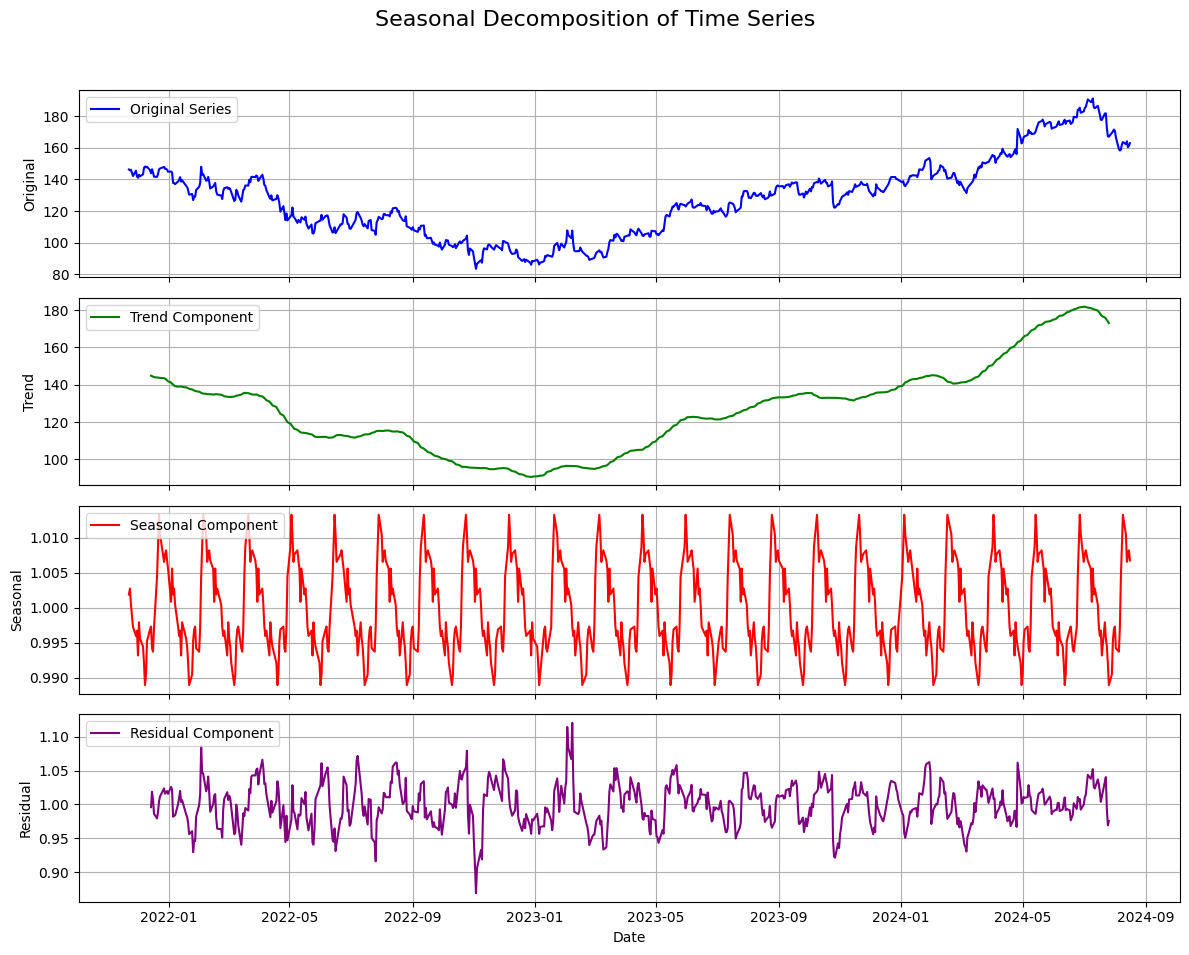

In [47]:
# Perform seasonal decomposition
decompose = seasonal_decompose(df['Close'], model='multiplicative', period=30)  # Use period that matches your data frequency

# Plot decomposition results
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)
fig.suptitle('Seasonal Decomposition of Time Series', fontsize=16)

# Original Series
axes[0].plot(df.index, df['Close'], label='Original Series', color='blue')
axes[0].set_ylabel('Original')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Trend Component
axes[1].plot(decompose.trend.index, decompose.trend, label='Trend Component', color='green')
axes[1].set_ylabel('Trend')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Seasonal Component
axes[2].plot(decompose.seasonal.index, decompose.seasonal, label='Seasonal Component', color='red')
axes[2].set_ylabel('Seasonal')
axes[2].legend(loc='upper left')
axes[2].grid(True)

# Residual Component
axes[3].plot(decompose.resid.index, decompose.resid, label='Residual Component', color='purple')
axes[3].set_ylabel('Residual')
axes[3].legend(loc='upper left')
axes[3].grid(True)

# Common X-axis label
axes[3].set_xlabel('Date')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

To check stationarity of DATA 


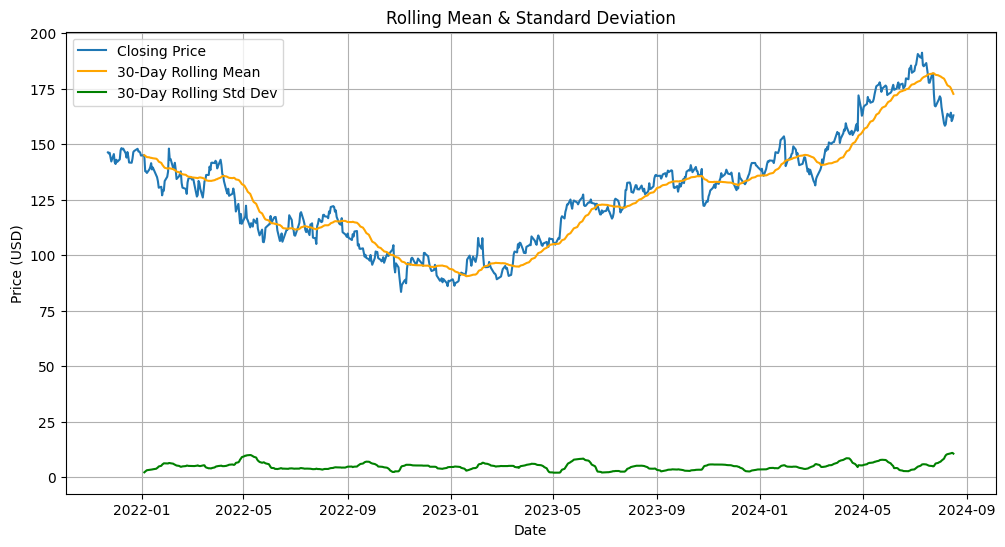

In [48]:
print('To check stationarity of DATA ')
window_size = 30
rolling_mean = df_cleaned['Close'].rolling(window=window_size).mean()
rolling_std = df_cleaned['Close'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Close'], label='Closing Price')
plt.plot(rolling_mean, label=f'{window_size}-Day Rolling Mean', color='orange')
plt.plot(rolling_std, label=f'{window_size}-Day Rolling Std Dev', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


The data is not stationary as mean is changing over time

Why `PACF` is Important
Determines AR Order (p): In an ARIMA model, the order of the autoregressive (AR) component (p) indicates how many previous time steps are used to predict the current time step. The PACF helps in determining this order by showing which lags have a direct effect on the current value.

Why `ACF` is Important
Determines MA Order (q): In an ARIMA model, the order of the moving average (MA) component (q) indicates how many past forecast errors are used to predict future values. The ACF helps in determining this order by showing which lags significantly affect the current value, after accounting for intermediate lags.

To decide the order of P and Q in ARIMA model 


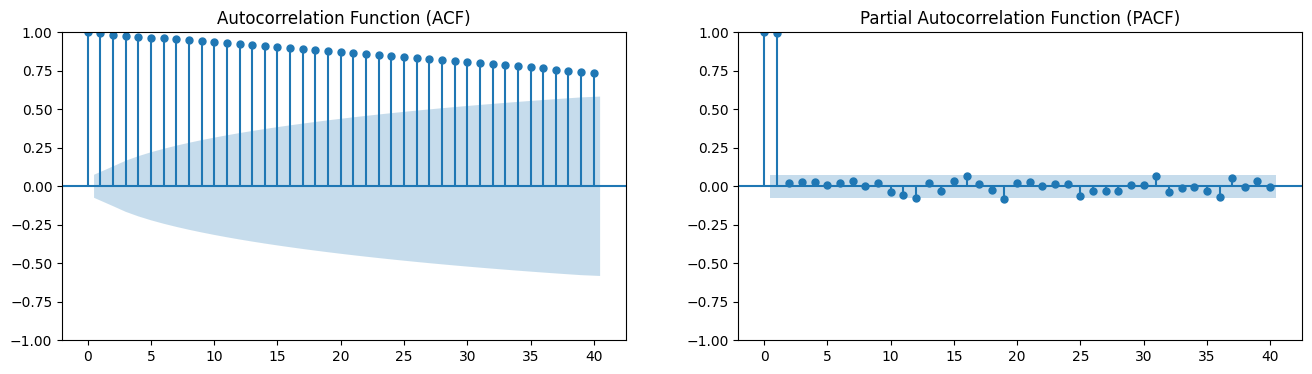

In [49]:
print("To decide the order of P and Q in ARIMA model ")
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_cleaned['Close'], lags=40, ax=axes[0])
plot_pacf(df_cleaned['Close'], lags=40, ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()


# Boxplot and Histogram #
Purpose: To detect outliers and understand the distribution of the gold stock closing prices.

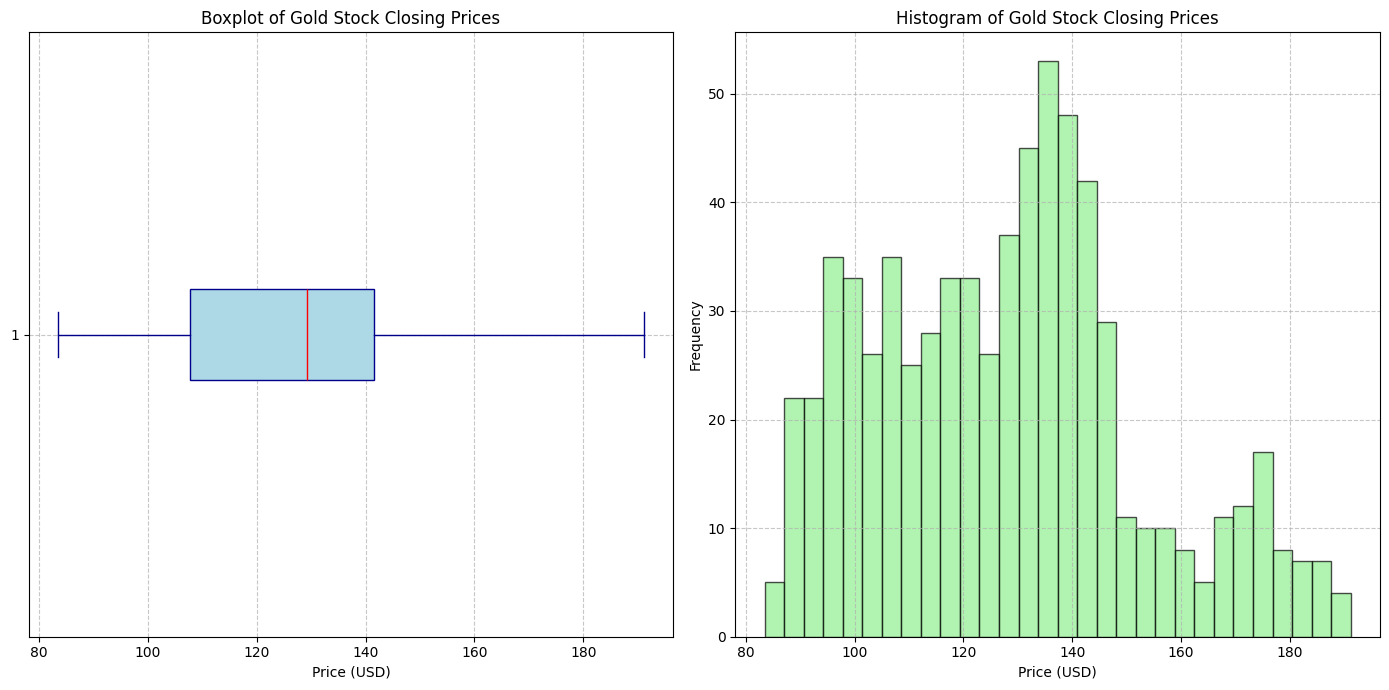

In [50]:
plt.figure(figsize=(14, 7))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Close'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='darkblue'),
            whiskerprops=dict(color='darkblue'),
            capprops=dict(color='darkblue'),
            medianprops=dict(color='red'))
plt.title('Boxplot of Gold Stock Closing Prices')
plt.xlabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Close'], bins=30, edgecolor='k', color='lightgreen', alpha=0.7)
plt.title('Histogram of Gold Stock Closing Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Lag Plot
Purpose: To visualize the relationship between the time series and its lagged version. This helps in identifying any inherent pattern.

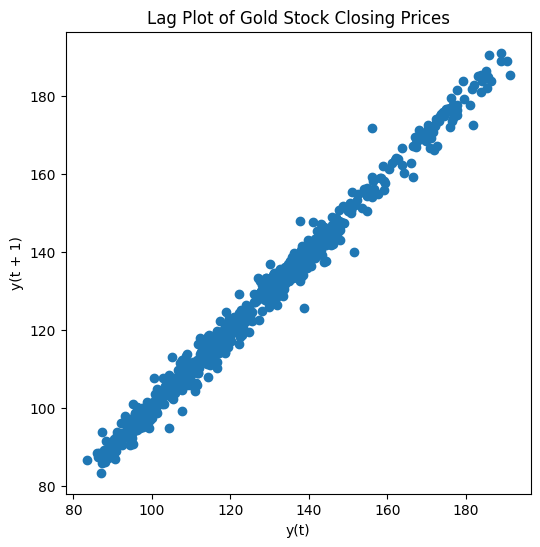

In [51]:
from pandas.plotting import lag_plot

plt.figure(figsize=(6, 6))
lag_plot(df_cleaned['Close'])
plt.title('Lag Plot of Gold Stock Closing Prices')
plt.show()

# Making time-series stationary

In [52]:
# Function to perform the ADF test
def adfuller_test(series, signif=0.05, name='', verbose=True):
    """Perform ADFuller to test for Stationarity of given series and print report."""
    r = adfuller(series, autolag='AIC')
    output = {'Test Statistic': r[0], 'p-value': r[1], 'Lags Used': r[2], 'Number of Observations Used': r[3]}
    output.update({f'Critical Value {k}': v for k, v in r[4].items()})
    if verbose:
        print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["Test Statistic"]:.3f}')
        print(f' No. Lags Chosen       = {output["Lags Used"]}')

        for key, value in r[4].items():
            print(f' Critical value {key}   = {value:.3f}')

        print(f' => P-Value = {output["p-value"]:.4f}')
        if output["p-value"] <= signif:
            print(f" => Series is Stationary.")
        else:
            print(f" => Series is Non-Stationary.")

# Assuming 'df_cleaned' is your DataFrame and 'Close' is the column you're testing
adfuller_test(df_cleaned['Close'], name='Close')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.119
 No. Lags Chosen       = 0
 Critical value 1%   = -3.440
 Critical value 5%   = -2.866
 Critical value 10%   = -2.569
 => P-Value = 0.7075
 => Series is Non-Stationary.


# Differencing

In [53]:
df_cleaned['Close Price Difference'] = df_cleaned['Close'] - df_cleaned['Close'].shift(1)

C:\Users\omshr\AppData\Local\Temp\ipykernel_25376\902909847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Close Price Difference'] = df_cleaned['Close'] - df_cleaned['Close'].shift(1)


In [54]:
df_cleaned.head(5)

,Close,Close Price Difference
Date,,
2021-11-22,146.302002,NaN
2021-11-23,145.781998,-0.520004
2021-11-24,146.119995,0.337997
2021-11-26,142.182999,-3.936996
2021-11-29,145.530502,3.347504


To check stationarity of DATA on differenced series


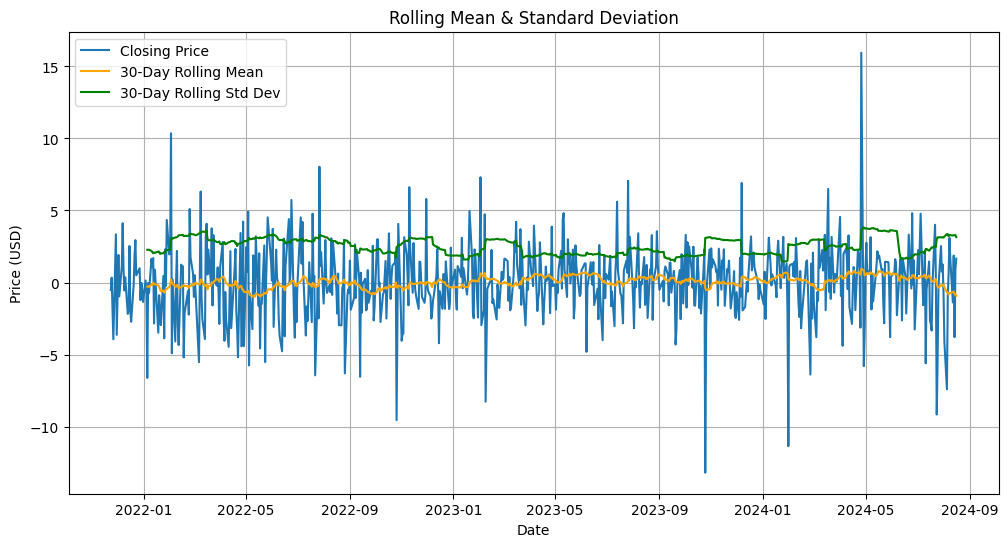

In [55]:
print('To check stationarity of DATA on differenced series')
window_size = 30
rolling_mean = df_cleaned['Close Price Difference'].rolling(window=window_size).mean()
rolling_std = df_cleaned['Close Price Difference'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Close Price Difference'], label='Closing Price')
plt.plot(rolling_mean, label=f'{window_size}-Day Rolling Mean', color='orange')
plt.plot(rolling_std, label=f'{window_size}-Day Rolling Std Dev', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
df_cleaned.dropna(inplace=True)

C:\Users\omshr\AppData\Local\Temp\ipykernel_25376\2343921619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(inplace=True)


In [57]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 686 entries, 2021-11-23 to 2024-08-16
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Close                   686 non-null    float64
 1   Close Price Difference  686 non-null    float64
dtypes: float64(2)
memory usage: 16.1 KB


In [58]:
df_cleaned.head()

,Close,Close Price Difference
Date,,
2021-11-23,145.781998,-0.520004
2021-11-24,146.119995,0.337997
2021-11-26,142.182999,-3.936996
2021-11-29,145.530502,3.347504
2021-11-30,141.897507,-3.632996


In [59]:
adfuller_test(df_cleaned['Close Price Difference'], name='Close Price Difference')

    Augmented Dickey-Fuller Test on "Close Price Difference" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.679
 No. Lags Chosen       = 0
 Critical value 1%   = -3.440
 Critical value 5%   = -2.866
 Critical value 10%   = -2.569
 => P-Value = 0.0000
 => Series is Stationary.


After differencing we converted series to stationarity.

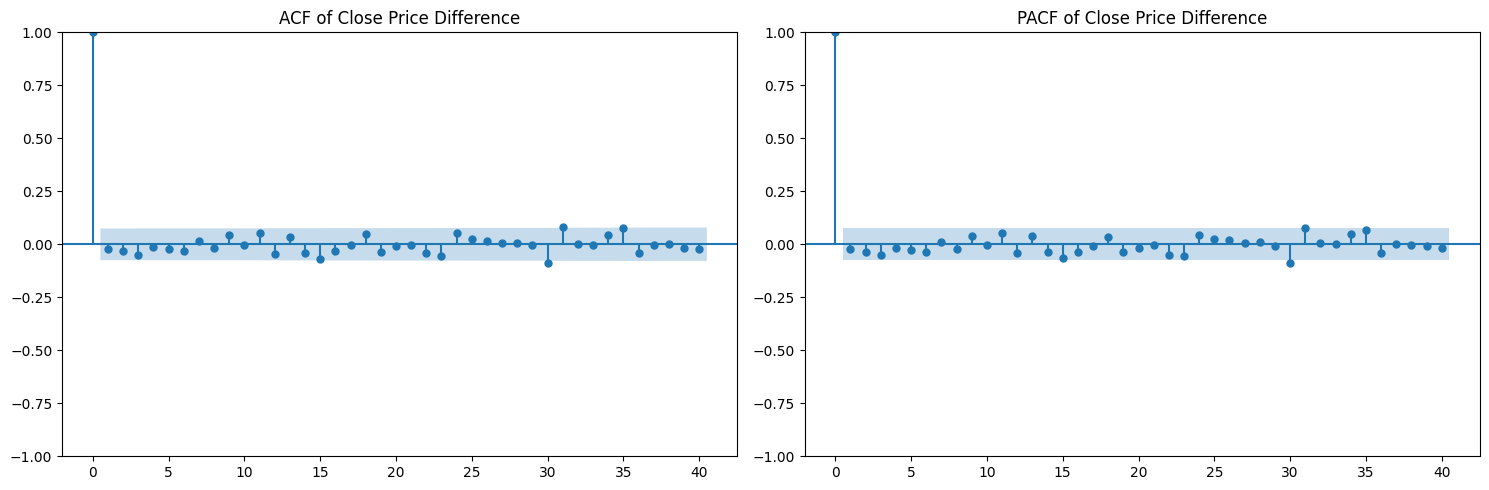

In [60]:
# Plotting ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(df_cleaned['Close Price Difference'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF of Close Price Difference')

# PACF plot
plot_pacf(df_cleaned['Close Price Difference'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Close Price Difference')

plt.tight_layout()
plt.show()


# Final Thoughts on Autocorrelation and Partial Autocorrelation #
Identification of an `AR model is often best done with the PACF`.

* For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF. p,d,q

* For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

`p AR` model `lags d` `differencing q` MA lags

# model Building


* # 1->Arima

In [61]:
pacf_vals = pd.DataFrame(pacf(df_cleaned['Close']))
acf_vals = pd.DataFrame(acf(df_cleaned['Close']))

In [62]:
pacf_vals.head(5) #GOT P=2

,0
0,1.000000
1,0.993887
2,0.025336
3,0.049340
4,0.004578


In [63]:
# Setting p and d values based on prior knowledge or experimentation
p = 2
d = 1

# List to store the AIC values for each q
aic_values = []
q_values = range(0, 5)  # Define the range of q values to test (you can adjust the range as needed)

# Loop over each q value and fit the ARIMA model
for q in q_values:
    try:
        # Fit the ARIMA model
        model = ARIMA(df_cleaned['Close'], order=(p, d, q))
        model_fit = model.fit()

        # Record the AIC value
        aic = model_fit.aic
        aic_values.append((q, aic))
        
        print(f'ARIMA({p}, {d}, {q}) - AIC: {aic:.2f}')
    except Exception as e:
        # If the model fails to converge or other issues occur, print the error and continue
        print(f'ARIMA({p}, {d}, {q}) - Error: {e}')

# Find the q value with the lowest AIC
best_q, best_aic = min(aic_values, key=lambda x: x[1])

In [64]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df_cleaned.iloc[:train_size], df_cleaned.iloc[train_size:]

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 549 entries, 2021-11-23 to 2024-01-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Close                   549 non-null    float64
 1   Close Price Difference  549 non-null    float64
dtypes: float64(2)
memory usage: 12.9 KB


In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2024-02-01 to 2024-08-16
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Close                   137 non-null    float64
 1   Close Price Difference  137 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


In [67]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
# Fit the ARIMA model on the training data
p = 2
d = 1
q = 4
model = ARIMA(train['Close'], order=(p, d, q))
model_fit = model.fit()

c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  549
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1280.603
Date:                Sat, 17 Aug 2024   AIC                           2575.206
Time:                        23:40:45   BIC                           2605.349
Sample:                             0   HQIC                          2586.987
                                - 549                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2222      3.137      0.390      0.697      -4.926       7.371
ar.L2         -0.3365      2.632     -0.128      0.898      -5.495       4.822
ma.L1         -1.2315      3.142     -0.392      0.695      -7.390       4.927
ma.L2          0.3145      2.671      0.118      0.906      -4.920       5.549
ma.L3         -0.0020      0.095     -0.021      0.983      -0.187       0.183
ma.L4         -0.0053      0.091     -0.058      0.954      -0.184       0.174
sigma2         6.2699      0.258     24.262      0.000       5.763       6.776
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               172.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


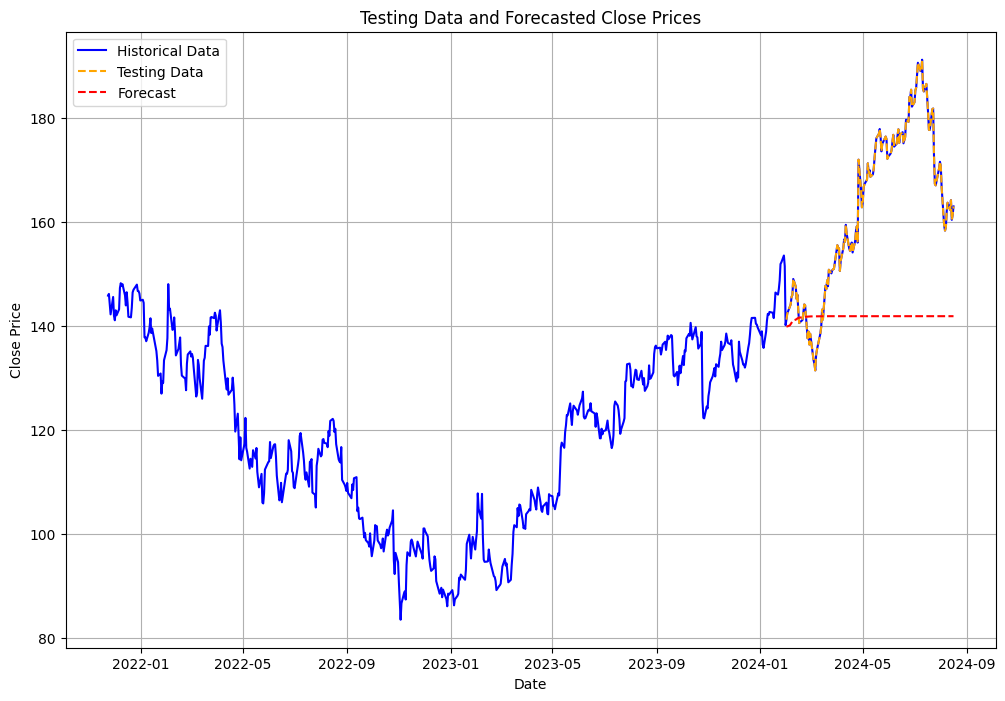

In [70]:
# Forecast the values for the testing period
forecast_steps = len(test)

# Generate the forecast from the end of the training data
forecast = model_fit.forecast(steps=forecast_steps)

test_df = pd.DataFrame(data=forecast.values,index=test.index)
test_df = test_df.rename(columns={0:'Forecast'})
test_df['Close'] = test['Close'].values

plt.figure(figsize=(12, 8))
plt.plot(df_cleaned.index, df_cleaned['Close'], label='Historical Data', color='blue')
plt.plot(test_df.index, test_df['Close'], label='Testing Data', color='orange', linestyle='--')
plt.plot(test_df.index, test_df['Forecast'], label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Testing Data and Forecasted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
mse = np.sqrt(np.mean((test_df['Close'] - test_df['Forecast']) ** 2))
print(f"root Mean Squared Error (RMSE): {mse}")

root Mean Squared Error (MSE): 25.859703767238823


* # 2 SARIMAX

In [72]:
df_seasonal = df[['Close']]

In [73]:
df_seasonal.head()

,Close
Date,
2021-11-22,146.302002
2021-11-23,145.781998
2021-11-24,146.119995
2021-11-26,142.182999
2021-11-29,145.530502


# DIFFERENCING

In [74]:
df_seasonal['seasonal Price Difference'] = df_seasonal['Close'] - df_seasonal['Close'].shift(30)

C:\Users\omshr\AppData\Local\Temp\ipykernel_25376\2555773511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seasonal['seasonal Price Difference'] = df_seasonal['Close'] - df_seasonal['Close'].shift(30)


To check stationarity of DATA on differenced series


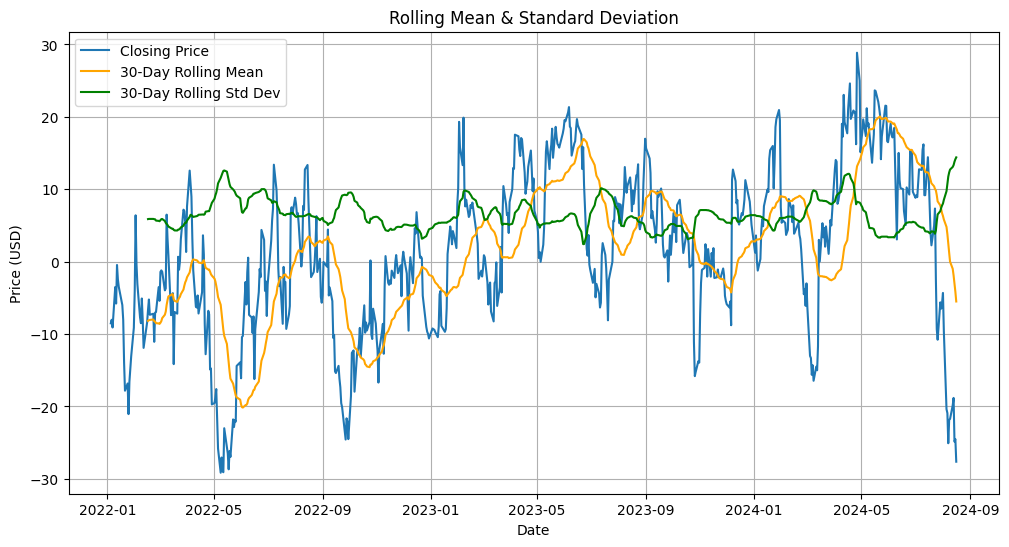

In [75]:
print('To check stationarity of DATA on differenced series')
window_size = 30
rolling_mean = df_seasonal['seasonal Price Difference'].rolling(window=window_size).mean()
rolling_std = df_seasonal['seasonal Price Difference'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df_seasonal['seasonal Price Difference'], label='Closing Price')
plt.plot(rolling_mean, label=f'{window_size}-Day Rolling Mean', color='orange')
plt.plot(rolling_std, label=f'{window_size}-Day Rolling Std Dev', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
adfuller_test(df_seasonal['seasonal Price Difference'].dropna(), name='seasonal Price Difference')

    Augmented Dickey-Fuller Test on "seasonal Price Difference" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.455
 No. Lags Chosen       = 12
 Critical value 1%   = -3.441
 Critical value 5%   = -2.866
 Critical value 10%   = -2.569
 => P-Value = 0.0092
 => Series is Stationary.


# Finetuning model to find optimal  param based on aic criterion

In [77]:
import itertools

# Assuming df_seasonal is your dataframe and the data has a DateTime index
data = df_seasonal['Close']

# Define the train-test split
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Define the p, d, q and P, D, Q, s ranges for the grid search
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = [30]

# Create a list of all possible combinations of the above parameters
parameter_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Store the best parameters and AIC result
best_aic, best_params = float("inf"), None

# Grid search to find the best parameters
for params in parameter_combinations:
    try:
        # Unpack the parameters
        p, d, q, P, D, Q, s = params

        # Create SARIMAX model
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, s),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        # Fit the model
        model_fit = model.fit(disp=False)

        # Get AIC
        aic = model_fit.aic

        # Store the parameters and score if they are the best so far
        if aic < best_aic:
            best_aic, best_params = aic, params

        print(f'Tested SARIMAX{params} - AIC: {aic:.4f}')
        
    except Exception as e:
        print(f'Error with parameters {params}: {e}')
        continue

print(f'Best SARIMAX{best_params} - AIC: {best_aic:.4f}')

# Fit the best model
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_params
best_model = sm.tsa.statespace.SARIMAX(train,
                                       order=(best_p, best_d, best_q),
                                       seasonal_order=(best_P, best_D, best_Q, best_s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
best_model_fit = best_model.fit(disp=False)

In [79]:
import statsmodels.api as sm


In [ ]:
# Assuming df_seasonal is your dataframe and the data has a DateTime index
data = df_seasonal['Close']

# Define the train-test split
train_size = int(len(data) * 0.8)
p=P = 2
q=Q = 4
d=D = 1 
s = 30
train, test = data[0:train_size], data[train_size:]
model = sm.tsa.statespace.SARIMAX(train,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, s),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

# Fit the model
model_fit = model.fit(disp=False)
model_fit.summary()

c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


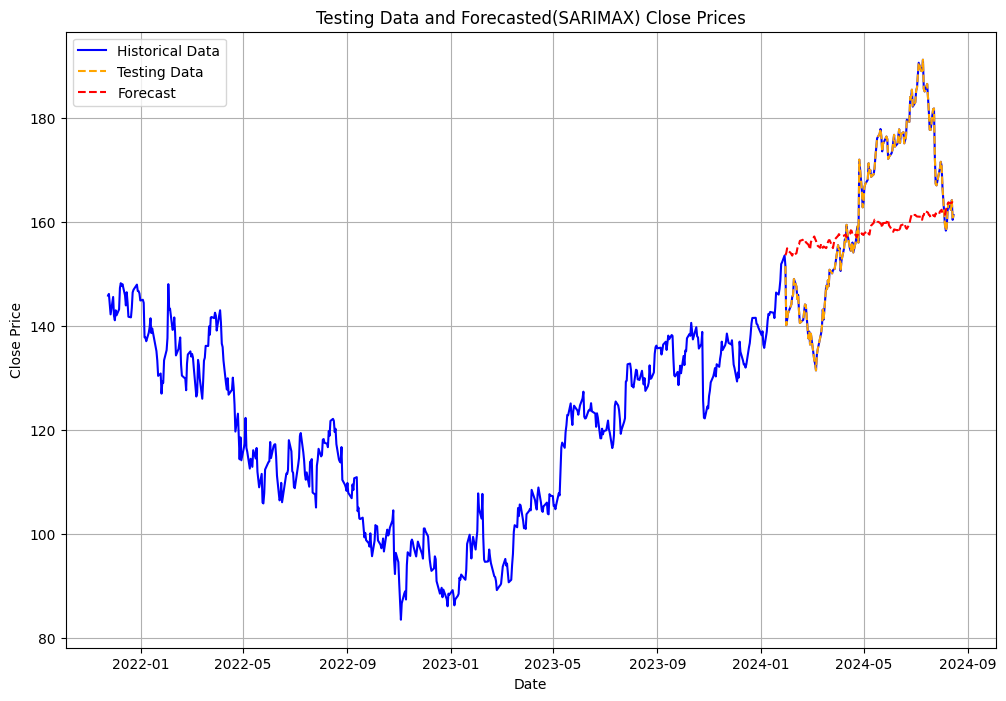

In [ ]:
# Forecast the values for the testing period
forecast_steps = len(test)

# Generate the forecast from the end of the training data
forecast = model_fit.forecast(steps=forecast_steps)

test_df = pd.DataFrame(data=forecast.values,index=test.index)
test_df = test_df.rename(columns={0:'Forecast'})
test_df['Close'] = test.values

plt.figure(figsize=(12, 8))
plt.plot(df_cleaned.index, df_cleaned['Close'], label='Historical Data', color='blue')
plt.plot(test_df.index, test_df['Close'], label='Testing Data', color='orange', linestyle='--')
plt.plot(test_df.index, test_df['Forecast'], label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Testing Data and Forecasted(SARIMAX) Close Prices')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate MSE
mse = np.mean((test_df['Close'] - test_df['Forecast']) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

root Mean Squared Error (MSE): 14.405377416628344


It perfomance is better than ARIMA but still not satisfying so lets moving towards deep learning models

* # 3->>LSTM

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Bidirectional
from keras.optimizers import SGD
from datetime import date

as DL is data hungry we need more data that arima family models so extracting more data for LSMT

In [3]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=5000)).strftime("%Y-%m-%d")
print("Start_date : ",start_date)
print("End_date : ",end_date)
ticker = 'GOOGL'
df = yf.download(ticker,start=start_date,end=end_date,progress=False)

Start_date :  2010-12-11
End_date :  2024-08-19


In [4]:
df_lstm = df[['Close']]

In [7]:
df_lstm.shape

(3442, 1)

In [5]:
train_size = int(df_lstm.shape[0] * 0.8)
train_size

2753

splitting into training and testing `8:2 ratio`

In [6]:
lstm_train,lstm_test = df_lstm[:train_size],df_lstm[train_size:]
print(lstm_train.shape,lstm_test.shape)

(2753, 1) (689, 1)


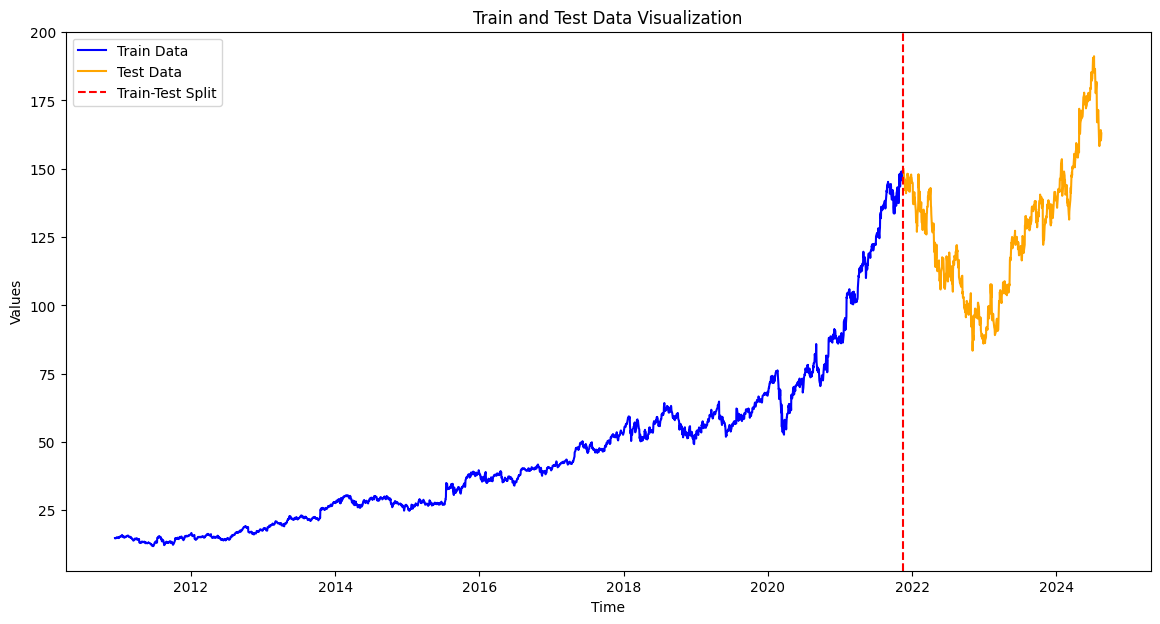

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the train and test data
plt.figure(figsize=(14, 7))  # Maximize representation by increasing figure size

# Plot training data
sns.lineplot(x=lstm_train.index, y=lstm_train['Close'], label='Train Data', color='blue')

# Plot testing data
sns.lineplot(x=lstm_test.index, y=lstm_test['Close'], label='Test Data', color='orange')

# Adding title and labels
plt.title('Train and Test Data Visualization')
plt.xlabel('Time')
plt.ylabel('Values')

# Adding a vertical line to separate train and test data visually
plt.axvline(x=lstm_train.index[-1], color='red', linestyle='--', label='Train-Test Split')

# Show legend
plt.legend()

# Display the plot
plt.show()


In [37]:
# Scaling the Training set
sc = MinMaxScaler(feature_range=(0, 1))
lstm_train_scaled = sc.fit_transform(lstm_train)

In [38]:
lstm_train_scaled[:2]

array([[0.02184877],
       [0.02190169]])

# preparing data for training an LSTM (Long Short-Term Memory) model.

In [39]:
# Initialize empty lists to hold the input sequences and target values
X_train = []
y_train = []

# Iterate over the dataset starting from the 60th time step
for i in range(60, lstm_train_scaled.size):
    # Append a sequence of 60 time steps to X_train
    # training_set_scaled[i-60:i, 0] extracts a slice of 60 time steps up to the current index i
    # The slice is from (i-60) to (i-1), capturing the last 60 time steps
    X_train.append(lstm_train_scaled[i-60:i, 0])
    
    # Append the target value (the value at index i) to y_train
    # This value is what we want to predict using the preceding 60 time steps
    y_train.append(lstm_train_scaled[i, 0])

# Convert the lists to NumPy arrays for efficient processing with machine learning models
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to be in the format (samples, time steps, features) required by LSTM models
# X_train.shape[0] is the number of sequences (samples)
# X_train.shape[1] is the number of time steps per sequence (in this case, 60)
# 1 is the number of features per time step (here, a univariate series with a single feature)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train,y_train = X_train.astype('float32'),y_train.astype('float32')


In [40]:
print(X_train.shape,y_train.shape) #it's became supervised machine learning problem now. with 60 features and univarite regression.
print(X_train[:,0],y_train[0])

(2693, 60, 1) (2693,)
[[0.02184876]
 [0.02190169]
 [0.02106051]
 ...
 [0.9154084 ]
 [0.9344536 ]
 [0.9433491 ]] 0.019235823


In [41]:
print(X_train.shape)
X_train[0][:5]

(2693, 60, 1)


array([[0.02184876],
       [0.02190169],
       [0.02106051],
       [0.02131779],
       [0.02115174]], dtype=float32)

In [42]:
print(y_train.shape)
y_train[:5]

(2693,)


array([0.01923582, 0.01858076, 0.01735457, 0.01727611, 0.01500255],
      dtype=float32)

checking if there any null values or not

In [43]:
print(np.isnan(X_train).any())  # Should print False
print(np.isinf(y_train).any())  # Should print False

False
False


# Building model's architecture

In [44]:

# Initialize the Sequential model
model = Sequential()

# Add LSTM layers with dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(60, 1), name='LSTM_1'))
model.add(Dropout(0.2, name='Dropout_1'))

model.add(LSTM(units=100, return_sequences=True, name='LSTM_2'))
model.add(Dropout(0.2, name='Dropout_2'))

model.add(LSTM(units=100, return_sequences=True, name='LSTM_3'))
model.add(Dropout(0.2, name='Dropout_3'))

model.add(LSTM(units=100, name='LSTM_4')) #want just single value per timestep i.e. univariate modelling thats why return_seq = False here DEFAULT
model.add(Dropout(0.2, name='Dropout_4'))

# Output layer
model.add(Dense(units=1, name='Output_Dense'))

# Compile the model with an optimizer and loss function
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), 
              loss='mean_squared_error', 
              metrics=['mean_squared_error'])

# Print model summary to see the architecture
model.summary()

c:\Users\omshr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Dense (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,101 (1.08 MB)

 Trainable params: 282,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,     # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Fitting the model to the training set
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=150, 
    verbose=1, 
    validation_split=0.2,  # Use a fraction of the training data for validation
    callbacks=[early_stopping]  # Add the early stopping callback
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.2271 - val_mean_squared_error: 0.2271
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.1275 - val_mean_squared_error: 0.1275
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.1049 - val_mean_squared_error: 0.1049
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0789 - val_mean_squared_error: 0.0789
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0

# Making Predictions

In [46]:
# Assuming scaler is the same one used for training data
# Scale the test data
lstm_test_scaled = sc.transform(lstm_test)
lstm_test_scaled = lstm_test_scaled.astype('float32')

2. Prepare the Data for Prediction
LSTM models usually require a 3D input of shape (samples, time_steps, features)

In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define the number of time steps used during training
time_steps = 60

# Prepare sequences and targets from the test data
lstm_test_sequences = []
lstm_test_targets = []

# Ensure lstm_test_scaled is a numpy array and not a pandas DataFrame or Series
lstm_test_scaled = np.array(lstm_test_scaled)

for i in range(time_steps, len(lstm_test_scaled)):
    lstm_test_sequences.append(lstm_test_scaled[i-time_steps:i, 0])
    lstm_test_targets.append(lstm_test_scaled[i, 0])

In [48]:

lstm_test_sequences = np.array(lstm_test_sequences)
lstm_test_targets = np.array(lstm_test_targets)

# Reshape the test data for LSTM input
lstm_test_sequences = np.reshape(lstm_test_sequences, (lstm_test_sequences.shape[0], lstm_test_sequences.shape[1], 1))

# Make predictions
predictions_scaled = model.predict(lstm_test_sequences)

# Inverse transform the predictions to get the original scale
predictions = sc.inverse_transform(predictions_scaled)

# Prepare actual target values
# Note: If lstm_test is a pandas DataFrame or Series, use iloc to index
lstm_test_targets = np.array(lstm_test_targets).reshape(-1, 1)
lstm_test_targets_unscaled = sc.inverse_transform(lstm_test_targets)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(lstm_test_targets_unscaled, predictions))
mae = mean_absolute_error(lstm_test_targets_unscaled, predictions)
r2 = r2_score(lstm_test_targets_unscaled, predictions)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2+}")


Root Mean Squared Error: 18.896678924560547
Mean Absolute Error: 15.27698040008545
R-squared: 0.707311658859253


In [37]:
print(lstm_test_sequences.shape,lstm_test_targets.shape) #accessing shape of our data
predictions.shape #shape of prediction

(629, 60, 1) (629, 1)


(629, 1)

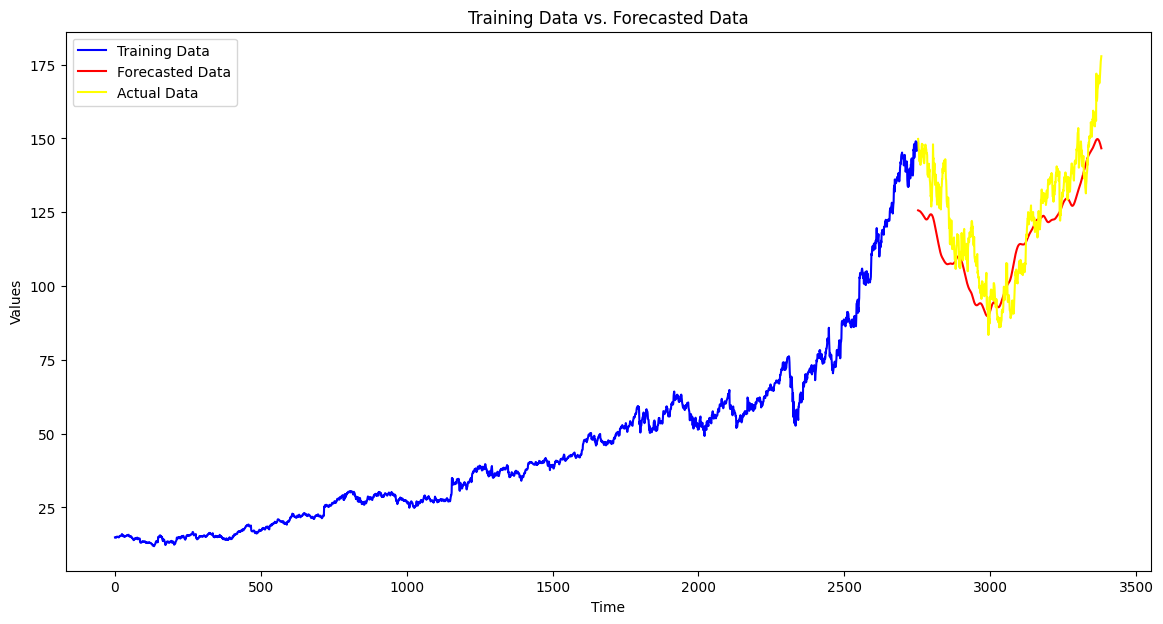

In [33]:
# Combine training data with predictions
combined_data = np.concatenate((lstm_train, predictions), axis=0)

# Create a time index for plotting
# Adjust indices based on the length of your training data and predictions
time_index_train = np.arange(len(lstm_train))
time_index_pred = np.arange(len(lstm_train), len(lstm_train) + len(predictions))

plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(time_index_train, lstm_train, color='blue', label='Training Data')

# Plot forecasted data
plt.plot(time_index_pred, predictions, color='red', label='Forecasted Data')

plt.plot(time_index_pred, lstm_test[0:629], color='yellow', label='Actual Data')

# Adding title and labels
plt.title('Training Data vs. Forecasted Data')
plt.xlabel('Time')
plt.ylabel('Values')

# Show legend
plt.legend()

# Display the plot
plt.show()

we are able to improve perfomance drastically

# Again now using  `BI-LSTM`

In [7]:
bi_lstm_train,bi_lstm_test = lstm_train,lstm_test

In [60]:
from tensorflow.keras.layers import  InputLayer

# Define the bidirectional LSTM model
model = Sequential()

# Add InputLayer with the input shape
model.add(InputLayer(input_shape=(bi_lstm_train.shape[1], 1)))

# Add Bidirectional LSTM layers with dropout for regularization
model.add(Bidirectional(LSTM(units=100, return_sequences=True, name='BiLSTM_1')))
model.add(Dropout(0.2, name='Dropout_1'))

model.add(Bidirectional(LSTM(units=100, return_sequences=True, name='BiLSTM_2')))
model.add(Dropout(0.2, name='Dropout_2'))

model.add(Bidirectional(LSTM(units=100, return_sequences=True, name='BiLSTM_3')))
model.add(Dropout(0.2, name='Dropout_3'))

model.add(Bidirectional(LSTM(units=100, name='BiLSTM_4')))
model.add(Dropout(0.2, name='Dropout_4'))

model.add(Dense(units=1, name='Output'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 1, 200)         │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 1, 200)         │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 1, 200)         │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,201 (3.07 MB)

 Trainable params: 804,201 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
bi_lstm_train_scaled = sc.fit_transform(bi_lstm_train)
bi_lstm_test_scaled = sc.transform(bi_lstm_test)

# Initialize empty lists to hold the input sequences and target values
X_train = []
y_train = []

# Iterate over the dataset starting from the 60th time step
for i in range(60, len(bi_lstm_train_scaled)):
    # Ensure index is within range
    if i - 60 >= 0:
        X_train.append(bi_lstm_train_scaled[i-60:i, 0])
        y_train.append(bi_lstm_train_scaled[i, 0])

# Convert the lists to NumPy arrays for efficient processing with machine learning models
X_train, y_train = np.array(X_train), np.array(y_train)

# Check the shapes of X_train and y_train
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Reshape X_train to be in the format (samples, time steps, features) required by LSTM models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


Shape of X_train: (2693, 60)
Shape of y_train: (2693,)


In [14]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, 
    y_train,  # Ensure y_train is aligned with bi_lstm_train
    epochs=50,
    batch_size=150,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 762ms/step - loss: 0.0119 - val_loss: 0.0200
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - loss: 9.4919e-04 - val_loss: 0.0046
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 626ms/step - loss: 4.1768e-04 - val_loss: 0.0073
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - loss: 2.9468e-04 - val_loss: 0.0048
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 651ms/step - loss: 2.8023e-04 - val_loss: 0.0049
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - loss: 2.3720e-04 - val_loss: 0.0038
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 736ms/step - loss: 2.2597e-04 - val_loss: 0.0032
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 872ms/step - loss: 2.0761e-04 - val_loss: 0.0050
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 877ms/step - loss: 2.1850e-04 - val_loss: 0.0045
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 879ms/step - loss: 2.2308e-04 - val_loss: 0.0039
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 879ms/step - loss: 2.0223e-04 - val_loss: 0.0020
Epo

In [17]:
# Assuming scaler is the same one used for training data
# Scale the test data
bi_lstm_test_scaled = sc.transform(lstm_test)
bi_lstm_test_scaled = bi_lstm_test_scaled.astype('float32')

In [19]:
# Define the number of time steps used during training
time_steps = 60

# Prepare sequences and targets from the test data
bi_lstm_test_sequences = []
bi_lstm_test_targets = []

# Ensure lstm_test_scaled is a numpy array and not a pandas DataFrame or Series
bi_lstm_test_scaled = np.array(bi_lstm_test_scaled)

for i in range(time_steps, len(bi_lstm_test_scaled)):
    bi_lstm_test_sequences.append(bi_lstm_test_scaled[i-time_steps:i, 0])
    bi_lstm_test_targets.append(bi_lstm_test_scaled[i, 0])

In [22]:

bi_lstm_test_sequences = np.array(bi_lstm_test_sequences)
bi_lstm_test_targets = np.array(bi_lstm_test_targets)

# Reshape the test data for LSTM input
bi_lstm_test_sequences = np.reshape(bi_lstm_test_sequences, (bi_lstm_test_sequences.shape[0], bi_lstm_test_sequences.shape[1], 1))

# Make predictions
predictions_scaled = model.predict(bi_lstm_test_sequences)

# Inverse transform the predictions to get the original scale
predictions = sc.inverse_transform(predictions_scaled)

# Prepare actual target values
# Note: If lstm_test is a pandas DataFrame or Series, use iloc to index
bi_lstm_test_targets = np.array(bi_lstm_test_targets).reshape(-1, 1)
bi_lstm_test_targets_unscaled = sc.inverse_transform(bi_lstm_test_targets)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(bi_lstm_test_targets_unscaled, predictions))
mae = mean_absolute_error(bi_lstm_test_targets_unscaled, predictions)
r2 = r2_score(bi_lstm_test_targets_unscaled, predictions)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Root Mean Squared Error: 10.30180835723877
Mean Absolute Error: 8.144150733947754
R-squared: 0.8297942280769348


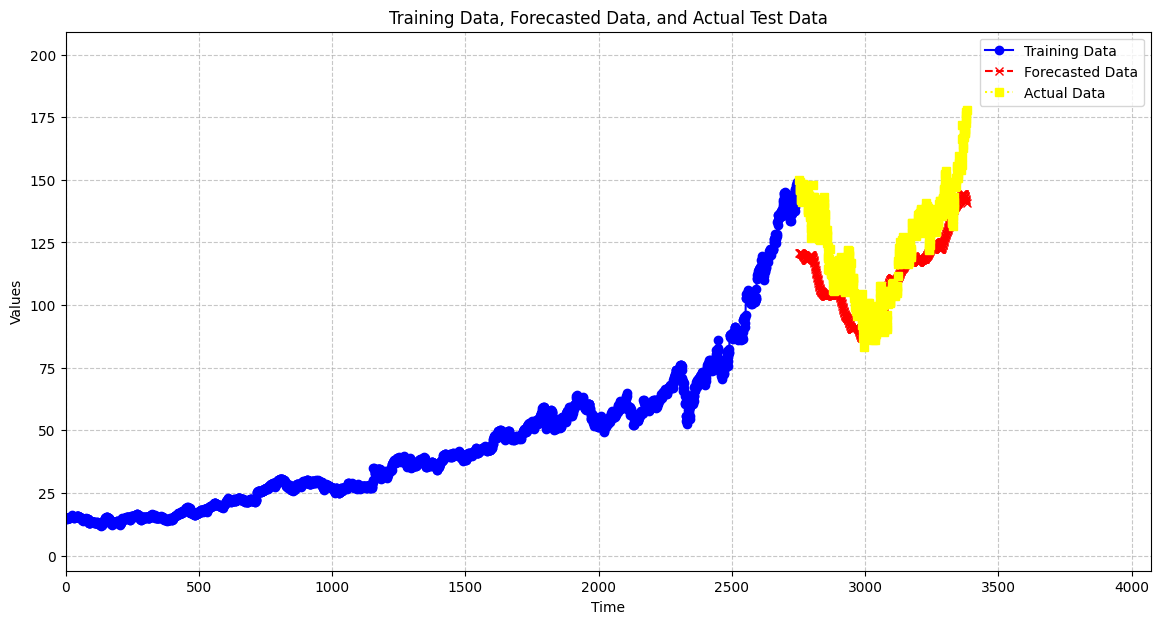

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Combine training data with predictions
combined_data = np.concatenate((bi_lstm_train, predictions, bi_lstm_test), axis=0)

# Create a time index for plotting
time_index_train = np.arange(len(bi_lstm_train))
time_index_pred = np.arange(len(bi_lstm_train), len(bi_lstm_train) + len(predictions))
time_index_test = np.arange(len(bi_lstm_train) + len(predictions), len(bi_lstm_train) + len(predictions) + len(bi_lstm_test))

plt.figure(figsize=(14, 7))

# Plot training data with a solid blue line
plt.plot(time_index_train, bi_lstm_train, color='blue', linestyle='-', marker='o', label='Training Data')

# Plot forecasted data with a dashed red line
plt.plot(time_index_pred, predictions, color='red', linestyle='--', marker='x', label='Forecasted Data')

# Plot actual test data with a dotted yellow line
plt.plot(time_index_pred, bi_lstm_test[:len(predictions)], color='yellow', linestyle=':', marker='s', label='Actual Data')

# Set limits for x-axis and y-axis to maximize representation
plt.xlim(0, len(bi_lstm_train) + len(predictions) + len(bi_lstm_test))
plt.ylim(min(combined_data) - 0.1 * np.ptp(combined_data), max(combined_data) + 0.1 * np.ptp(combined_data))

# Adding title and labels
plt.title('Training Data, Forecasted Data, and Actual Test Data')
plt.xlabel('Time')
plt.ylabel('Values')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show legend
plt.legend()

# Display the plot
plt.show()
